In [1]:
SIGNAL = "vocindex"
GAP_THRESHOLD = "2min"

# Valid reading limits
LOWER_LIMIT = 0
UPPER_LIMIT = 500

# Noise detection rolling window size
NOISE_WINDOW = 10

# Gap synthesis
SYNTHESISE_GAP = False
SYNTHETIC_GAP_LENGTH = "10min"

# Out-of-range value synthesis
SYNTHESISE_OOR_VALUES = False
NUMBER_SYNTHETIC_LOW = 10
NUMBER_SYNTHETIC_HIGH = 10
OOR_MARGIN = 5

In [2]:
%run pathutils.ipynb
%run database.ipynb
%run export.ipynb

In [3]:
import pandas as pd

# Load the readings
df = load_sensor_readings("sgp40")

# Parse timestamp as timezone-aware UTC, set it as the index and sort
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
df = df.set_index('timestamp').sort_index()

# Preview the data
df.head()

,sraw,vocindex,label,rating
timestamp,,,,
2025-12-06 16:07:21+00:00,30754,0,Excellent,*****
2025-12-06 16:08:24+00:00,30778,40,Excellent,*****
2025-12-06 16:09:26+00:00,30795,95,Good,****
2025-12-06 16:10:28+00:00,30806,97,Good,****
2025-12-06 16:11:30+00:00,30821,98,Good,****


# Synthetic Gaps for Testing

In [4]:
import pandas as pd

if SYNTHESISE_GAP:
    # Calculate the number of rows to remove: ~5% of the dataset, at least 5 rows
    n = len(df)
    rows_to_remove = max(int(n * 0.05), 5)

    # Choose a block in the middle
    start_pos = n // 2
    end_pos = min(start_pos + rows_to_remove, n - 1)

    # Identify the gap indices
    gap_index = df.index[start_pos:end_pos]
    print("Fake gap rows from", gap_index[0], "to", gap_index[-1])
    display(df[gap_index[0]:gap_index[-1]])

    # Drop those rows to create a time gap
    df = df.drop(gap_index)

# Synthetic Out-of-Range (OOR) Values for Testing

In [5]:
import numpy as np

if SYNTHESISE_OOR_VALUES:
    rng = np.random.default_rng(None)

    # Only pick indices where the column is non-null
    valid_idx = df[df[SIGNAL].notna()].index

    if len(valid_idx) == 0:
        raise ValueError(f"No valid data in column '{SIGNAL}' to corrupt")

    # Clamp counts so we don't exceed available points
    n_low = min(NUMBER_SYNTHETIC_LOW, len(valid_idx))
    n_high = min(NUMBER_SYNTHETIC_LOW, len(valid_idx))

    # Randomly choose indices for low and high OOR values
    low_idx = rng.choice(valid_idx, size=n_low, replace=False)
    remaining_idx = valid_idx.difference(low_idx)
    high_idx = rng.choice(remaining_idx, size=n_high, replace=False)

    # Inject low-side OOR values
    df.loc[low_idx, SIGNAL] = LOWER_LIMIT - OOR_MARGIN

    # Inject high-side OOR values
    df.loc[high_idx, SIGNAL] = UPPER_LIMIT + OOR_MARGIN

# Sensor Health Analysis

In [6]:
import pandas as pd

# Calculate the time delta between samples and identify gaps larger than expected
df['dt'] = pd.to_timedelta(df.index.diff(), errors='coerce')
df['is_gap'] = df['dt'] > pd.Timedelta(GAP_THRESHOLD)
df['segment_id'] = df['is_gap'].cumsum()

# Create a gaps dataframe
gaps = df[df['is_gap']].copy()

if not gaps.empty:
    # gap_end: where data resumes
    gaps['gap_end'] = gaps.index

    # gap_start: previous timestamp in the original df
    prev_index = df.index.to_series().shift(1)
    gaps['gap_start'] = prev_index.loc[gaps.index]

    # duration and midpoint
    gaps['gap_duration'] = gaps['gap_end'] - gaps['gap_start']
    gaps['gap_mid'] = gaps['gap_start'] + gaps['gap_duration'] / 2
else:
    print("No gaps detected above threshold.")

# Identify out-of-range values
df['oor'] = (df[SIGNAL] < LOWER_LIMIT) | (df[SIGNAL] > UPPER_LIMIT)
oor_points = df[df['oor']]

# Identify noise/variability within each segment, ignoring gaps
df['noise'] = (
    df.groupby('segment_id')[SIGNAL]
      .rolling(window=NOISE_WINDOW, min_periods=10)
      .std()
      .reset_index(level=0, drop=True)
)

# For each gap, mask values inside the interval with NaN so matplotlib won't draw lines across gaps
for _, row in gaps.iterrows():
    mask = (df.index >= row["gap_start"]) & (df.index <= row["gap_end"])
    df.loc[mask, SIGNAL] = np.nan

In [7]:
# Get the export folder path
export_folder_path = get_export_folder_path()

# Data Gaps

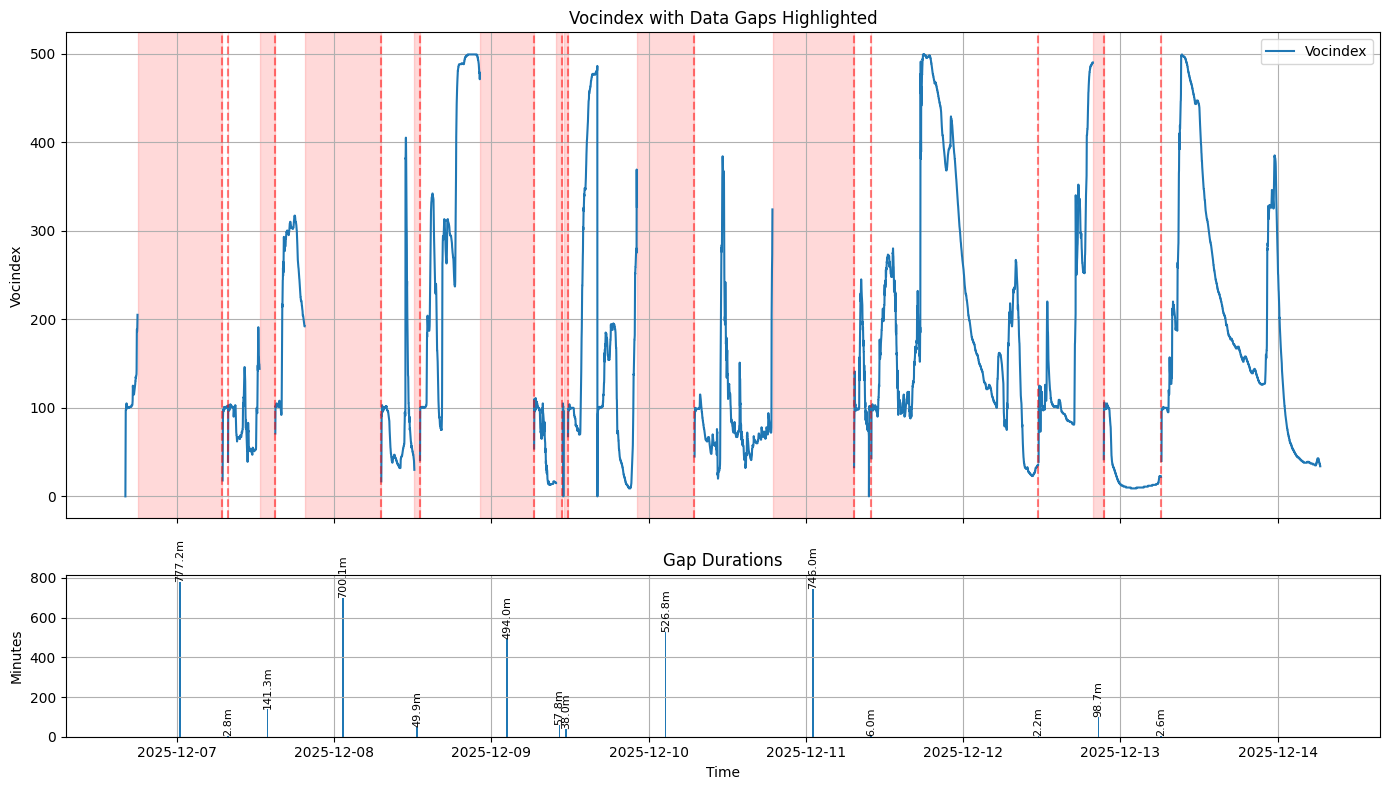

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(14, 8),
    sharex=True,
    gridspec_kw={'height_ratios': [3, 1]}
)

# -------------------------------
# Top: signal with shaded gaps + vertical markers
# -------------------------------
ax1.plot(df.index, df[SIGNAL], label=SIGNAL.capitalize())
ax1.set_ylabel(SIGNAL.capitalize())
ax1.set_title(f"{SIGNAL.capitalize()} with Data Gaps Highlighted")
ax1.grid(True)

if not gaps.empty:
    for _, g in gaps.iterrows():
        # Shaded region over the gap
        ax1.axvspan(g['gap_start'], g['gap_end'],
                    color='red', alpha=0.15)

        # Vertical marker at the gap end
        ax1.axvline(g['gap_end'],
                    color='red', alpha=0.5, linestyle='--')

ax1.legend()

# -------------------------------
# Bottom: gap duration bars
# -------------------------------
ax2.set_title("Gap Durations")
ax2.set_ylabel("Minutes")
ax2.grid(True)

if not gaps.empty:
    # Convert duration to minutes
    gap_minutes = gaps['gap_duration'].dt.total_seconds() / 60.0

    # Duration bars at gap midpoints
    ax2.bar(gaps['gap_mid'], gap_minutes,
            width=0.01, align='center')  # width is cosmetic here

    # Optional: annotate durations
    for _, g in gaps.iterrows():
        mins = g['gap_duration'].total_seconds() / 60.0
        ax2.text(g['gap_mid'], mins,
                 f"{mins:.1f}m",
                 ha='center', va='bottom', fontsize=8, rotation=90)

ax2.set_ylim(bottom=0)
ax2.set_xlabel("Time")

plt.tight_layout()

# Export to PNG or PDF, if required
export_chart(export_folder_path, f"sgp40_{SIGNAL}_gaps", "png")

plt.show()

# Out-of-Range Data

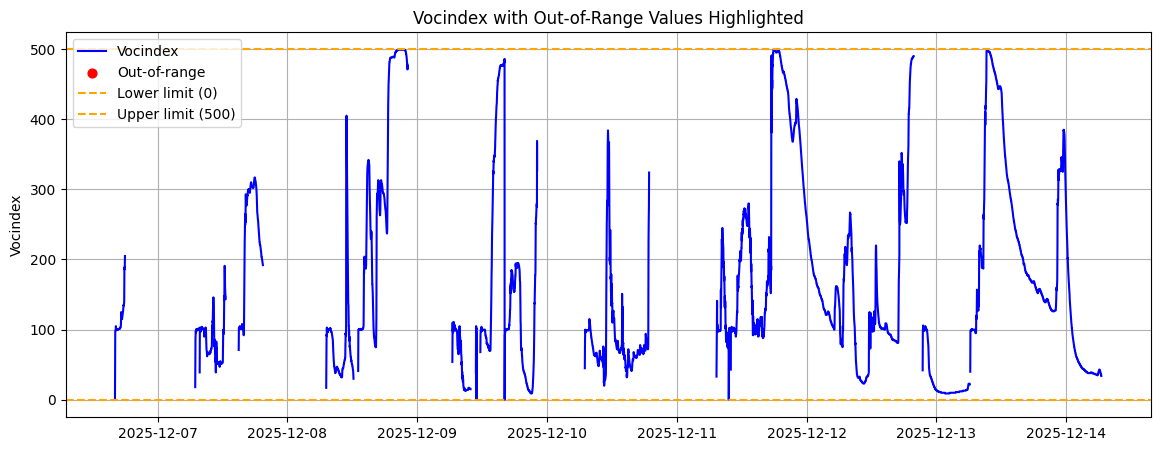

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 5))

# Plot the normal signal
ax.plot(df.index, df[SIGNAL], label=SIGNAL.capitalize(), color='blue')

# Plot out-of-range values as red circular markers
ax.scatter(
    oor_points.index,
    oor_points[SIGNAL],
    color='red',
    s=40,
    marker='o',
    label='Out-of-range'
)

# Draw limit lines
ax.axhline(LOWER_LIMIT, color='orange', linestyle='--', label=f'Lower limit ({LOWER_LIMIT})')
ax.axhline(UPPER_LIMIT, color='orange', linestyle='--', label=f'Upper limit ({UPPER_LIMIT})')

ax.set_title(f"{SIGNAL.capitalize()} with Out-of-Range Values Highlighted")
ax.set_ylabel(SIGNAL.capitalize())
ax.grid(True)
ax.legend()

# Export to PNG or PDF, if required
export_chart(export_folder_path, f"sgp40_{SIGNAL}_out_of_range", "png")

plt.show()

# Sensor Noise

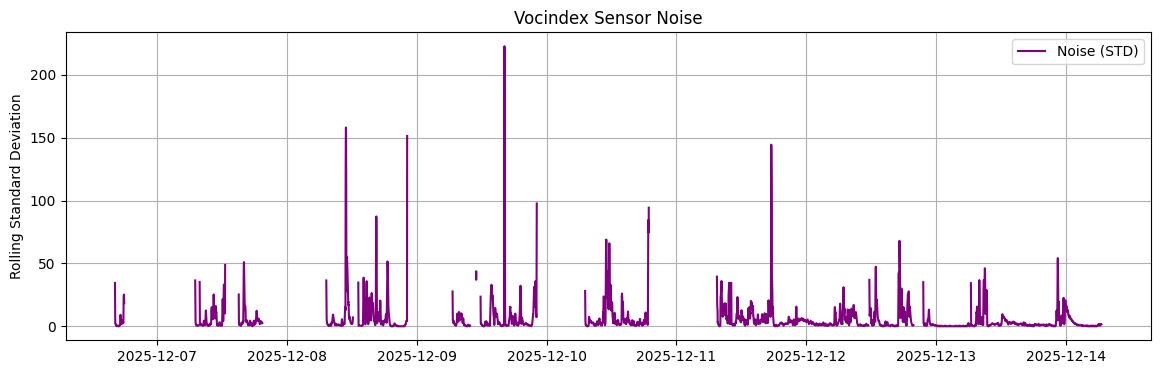

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,4))

ax.plot(df.index, df['noise'], label='Noise (STD)', color='purple')
ax.set_title(f"{SIGNAL.capitalize()} Sensor Noise")
ax.set_ylabel("Rolling Standard Deviation")
ax.grid(True)
ax.legend()

# Export to PNG or PDF, if required
export_chart(export_folder_path, f"sgp40_{SIGNAL}_noise", "png")

plt.show()